# Identifying Entities in Healthcare Data

## Workspace set up: Import and Install useful packages.

In [1]:
!pip install pycrf
!pip install sklearn-crfsuite



In [1]:
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

## Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line.
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

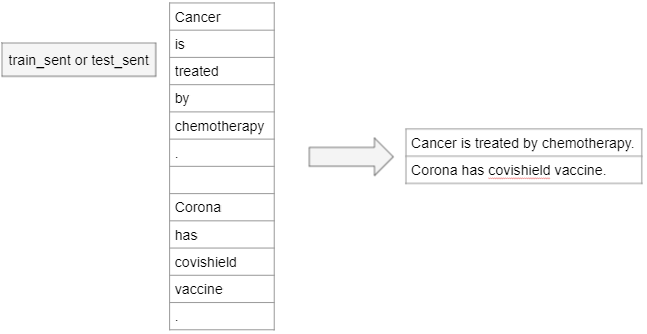

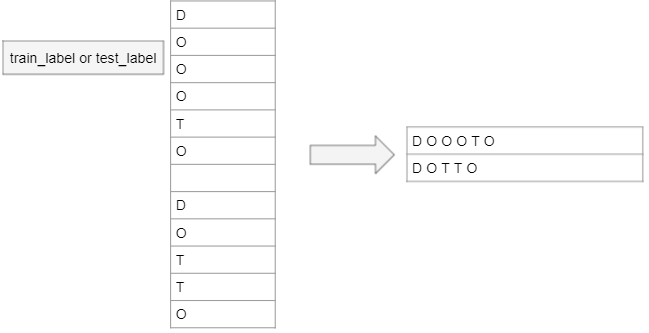

In [2]:

def extract_sentences_from_files(file_paths):
    sentences_dict = {}

    for file_path in file_paths:
        with open(file_path, 'r') as file:
            words = [word.strip() for word in file]

        sentences = []
        current_sentence = ""

        for word in words:
            if word:  # Check if the word is not an empty string
                current_sentence += word + " "
            else:
                # Add the completed sentence to the list
                sentences.append(current_sentence.strip())
                current_sentence = ""

        # Add the last sentence if there's any remaining text
        if current_sentence:
            sentences.append(current_sentence.strip())

        # Add sentences and count for the current file to the dictionary
        sentences_dict[file_path] = {
            'sentences': sentences,
            'sentence_count': len(sentences)
        }

    return sentences_dict

In [3]:
def construct_sentences_from_words(input_file_path, output_file_path):
    with open(input_file_path, 'r') as input_file, open(output_file_path, 'w') as output_file:
        sentences = []
        for line in input_file:
            line = line.strip()
            if line:  # Check if the line is not empty
                sentences.append(line)
            else:
                if sentences:
                    output_file.write(' '.join(sentences) + '\n\n')
                    sentences = []

        # Write the last sentence if any
        if sentences:
            output_file.write(' '.join(sentences) + '\n')

In [4]:
input_file_path1 = "train_sent"  # Replace with the actual file path
output_file_path1 = "train_sentences"  # Replace with the desired output file path
construct_sentences_from_words(input_file_path1, output_file_path1)

input_file_path2 = "train_label"  # Replace with the actual file path
output_file_path2 = "train_labels"  # Replace with the desired output file path
construct_sentences_from_words(input_file_path2, output_file_path2)

input_file_path3 = "test_sent"  # Replace with the actual file path
output_file_path3 = "test_sentences"  # Replace with the desired output file path
construct_sentences_from_words(input_file_path3, output_file_path3)

input_file_path4 = "test_label"  # Replace with the actual file path
output_file_path4 = "test_labels"  # Replace with the desired output file path
construct_sentences_from_words(input_file_path4, output_file_path4)

In [5]:
with open('train_sentences', 'r') as train_sent_file:
  train_sentences = train_sent_file.readlines()
with open('train_labels', 'r') as train_label_file:
  train_labels = train_label_file.readlines()
print(train_sentences[6])
print(train_labels[6])

The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )

O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O



In [6]:
with open('test_sentences', 'r') as train_sent_file:
  test_sentences = train_sent_file.readlines()
with open('test_labels', 'r') as test_label_file:
  test_labels = test_label_file.readlines()
print(test_sentences[6])
print(test_labels[6])

There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )

O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O



### Count the number of sentences in the processed train and test dataset

In [7]:
# File path:
file_paths = ["train_sent","test_sent"]
resulting_sentences = extract_sentences_from_files(file_paths)

# Print first 5 sentences and total no of sentences of train and test dataset
for file_path, data in resulting_sentences.items():
    print(f"File: {file_path}")
    # Print the first five sentences
    for sentence in data['sentences'][:5]:
        print(sentence)
    print(f"Total number of sentences: {data['sentence_count']}")
    print("\n-\n")

File: train_sent
All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )
Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )
Total number of sentences: 2599

-

File: test_sent
Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )
As the amb

### Count the number of lines of labels in the processed train and test dataset.

In [8]:
# File path:
file_paths = ["train_label","test_label"]
resulting_sentences = extract_sentences_from_files(file_paths)

# Print first 5 sentences and total no of sentences of train and test label
for file_path, data in resulting_sentences.items():
    print(f"File: {file_path}")
    # Print the first five sentences
    for sentence in data['sentences'][:5]:
        print(sentence)
    print(f"Total number of sentences: {data['sentence_count']}")
    print("\n-\n")

File: train_label
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
O O O O O O O O O O O O O O O O O O O O O O O O O
O O O O O O O O O O O O O O O
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
O O O O O O O O O O O O O O O O O O O O O O
Total number of sentences: 2599

-

File: test_label
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
O O O O O O O O O O O O O O O O O O O
O O O O O O O O O O O O O O O O O O O O O O O O
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
O O O O O O O O O O O
Total number of sentences: 1056

-



## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging.



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [9]:
import spacy
from collections import Counter


def extract_noun_propn_tokens(sentences):
    all_tokens = []

    for sentence in sentences:
        doc = model(sentence)
        # Extract tokens with NOUN or PROPN tags
        noun_propn_tokens = [token.text for token in doc if token.pos_ in ['NOUN', 'PROPN']]
        all_tokens.extend(noun_propn_tokens)

    return all_tokens



In [10]:
import os

def extract_sentences_from_directory(directory_path):
    sentences = []

    # Iterate through files in the directory
    for file_name in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file_name)

        # Check if the path is a file and not a subdirectory
        if os.path.isfile(file_path):
            with open(file_path, 'r') as file:
                words = [word.strip() for word in file]

            # Join the words to form sentences
            sentence = ' '.join(words)
            sentences.append(sentence)

    return sentences



In [11]:
def extract_sentences_from_file(file_path):
    with open(file_path, 'r') as file:
        words = [word.strip() for word in file]

    # Join the words to form a sentence
    sentence = ' '.join(words)
    return [sentence]

file_path = "train_sent"
resulting_sentences = extract_sentences_from_file(file_path)

In [12]:

# Extract NOUN and PROPN tokens from all sentences
noun_propn_tokens = extract_noun_propn_tokens(resulting_sentences)

# Calculate token frequency
token_frequency = Counter(noun_propn_tokens)

# Print the token frequency
#for token, frequency in token_frequency.items():
 #   print(f"{token}: {frequency} times")

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [13]:
# Print the top 25 most common tokens with NOUN or PROPN PoS tags
for token, frequency in token_frequency.most_common(25):
    print(f"{token}: {frequency} times")

patients: 354 times
treatment: 195 times
%: 161 times
cancer: 135 times
therapy: 120 times
disease: 105 times
study: 103 times
cell: 99 times
lung: 87 times
chemotherapy: 65 times
group: 63 times
effects: 61 times
gene: 55 times
TO_SEE: 55 times
use: 53 times
results: 53 times
surgery: 51 times
survival: 50 times
risk: 49 times
women: 48 times
care: 47 times
analysis: 47 times
dose: 47 times
children: 47 times
activity: 47 times


## Defining features for CRF





In [43]:
#Define a function to get the defined features for a word.

def getFeaturesForOneWord(sentence, pos):
  word = sentence[pos]

  features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'words.startsWithCapital=%s' % word[0].isupper() # is the word starting with a capital letter
  ]

  if(pos > 0):
    prev_word = sentence[pos-1]
    features.extend([
    'prev_word.lower=' + prev_word.lower(),
    'prev_word.isupper=%s' % prev_word.isupper(),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_words.startsWithCapital=%s' % prev_word[0].isupper()
  ])
  else:
    features.append('BEG') # feature to track begin of sentence

  if(pos == len(sentence)-1):
    features.append('END') # feature to track end of sentence

  return features

In [44]:
# Define a function to get features for a sentence
def getFeaturesForOneSentence(sentence):
  sentence_list = sentence.split()
  return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]

In [16]:
# Define a function to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
  return labels.split()

## Getting the features

### Write a code/function to get the features for a sentence

In [17]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sentences[6]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[2]

The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )



['word.lower=corrected',
 'word[-3:]=ted',
 'word[-2:]=ed',
 'word.isupper=False',
 'word.isdigit=False',
 'words.startsWithCapital=False',
 'prev_word.lower=``',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_words.startsWithCapital=False']

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset

In [18]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sentences]
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_labels]

X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sentences]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_labels]

### Define the labels as the target variable for test and the train dataset

## Build the CRF Model

In [25]:
!pip install -U scikit-learn
!pip install -U sklearn-crfsuite

  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\programdata\\anaconda3\\lib\\site-packages\\scipy-1.4.1.dist-info\\INSTALLER'
Consider using the `--user` option or check the permissions.



In [19]:
import sklearn_crfsuite

from sklearn_crfsuite import metrics

In [20]:
# Fit the CRF model
#%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

In [21]:
%%time

try:
    crf.fit(X_train, Y_train)
except AttributeError:
    pass


Wall time: 1.48 s


## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [22]:
y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [23]:
metrics.flat_f1_score(Y_test, y_pred, average='weighted')

0.9167333894754459

## Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

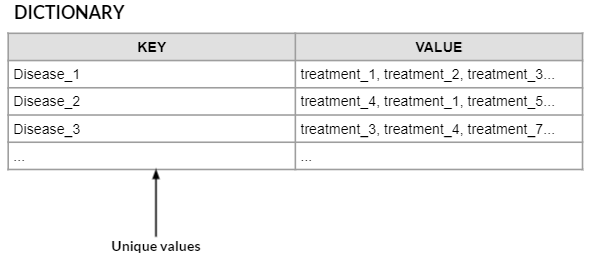

In [25]:
diseases_and_treatments =  {} # dictionary with disease as key an list of treatments as value

for i in range(len(y_pred)): # For each predicted sequence
  labels = y_pred[i]

  disease = "";
  treatment = "";
  
  for j in range(len(labels)): # for each individual label in the sequence
    if labels[j] == 'O': # ignore if label is O -- other
      continue

    if(labels[j] == 'D'): # Label D indicates disease, so add the corresponding word from test sentence to the disease name string
      disease += test_sentences[i].split()[j] + " "
      continue

    if(labels[j] == 'T'): # Label T indicates disease, so add the corresponding word from test sentence to the treatment name string
      #print(test_sentences[i].split()[j])
      treatment += test_sentences[i].split()[j] + " "

  disease = disease.strip() # to remove extraneous spaces
  treatment = treatment.strip()

  # add the identified disease and treatment to the dictionary
  # if it is a new disease, directly add the value
  # if the disease has been seen previously, get the treatment list
  # and add current treatment to the list.
  if disease is not "" and treatment is not "":
    if disease not in diseases_and_treatments.keys():
      diseases_and_treatments[disease] = [treatment]
    else:
      treatment_list = diseases_and_treatments.get(disease)
      treatment_list.append(treatment)
      diseases_and_treatments[disease] = treatment_list 

<>:28: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:28: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:28: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:28: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-25-19182b689001>:28: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if disease is not "" and treatment is not "":
<ipython-input-25-19182b689001>:28: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if disease is not "" and treatment is not "":


In [42]:
diseases_identified = list(diseases_and_treatments.keys())
index = 50

print("Disease: ",diseases_identified[index])
print("Treatment:", diseases_and_treatments.get(diseases_identified[index]))

Disease:  limited stage small cell lung cancer
Treatment: ['vip combination chemotherapy']


In [41]:
# Write a function to get the treatment from specified disease

def get_treatment_for_disease(disease_name, data):
    return data.get(disease_name, "Treatment information not available for this disease.")

disease = 'peritoneal tumors'
treatment = get_treatment_for_disease(disease, diseases_and_treatments)

print(f"Disease: {disease}")
print(f"Treatment: {treatment}")

Disease: peritoneal tumors
Treatment: ['Subcutaneous injection of irradiated LLC-IL2']
